In [1]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [211]:
#constructing our objective function
Nlim = 3# number of platns to be assigned - increase the Nlim for more number of locations

def create_random_matrix(n):
    return np.random.randint(1, 51, size=(n, n))
    
C = create_random_matrix(Nlim)  #cost of transporting one unit of energy from location i to location j
T = create_random_matrix(Nlim)  #number of units of energy to be transported from p to plant q

In [212]:
bqm = BinaryQuadraticModel('BINARY')  #Creating a BQM model

In [213]:
x = [[BinaryQuadraticModel('BINARY') for j in range(Nlim)] for i in range(Nlim)]

In [214]:
#Koopmans-Beckmann formulation
for q in range(Nlim):
    for p in range(Nlim):
        for i in range(Nlim):
            for j in range(Nlim):
                if (i != q) or (j != p):
                    bqm.add_interaction(f"x_{p}_{i}" , f"x_{j}_{q}", C[i][j] * T[p][q]) 

for p in range(Nlim):
    for i in range(Nlim):
        bqm.add_variable(f"x_{p}_{p}", C[i][i]*T[p][p])

In [215]:
for i in range(Nlim):
    c1 = [(f"x_{p}_{i}", 1) for p in range(Nlim)]
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=10)

In [216]:
for p in range(Nlim):
    c2 = [(f"x_{p}_{i}", 1) for i in range(Nlim)]
    bqm.add_linear_equality_constraint(c2, constant=-1, lagrange_multiplier = 20)

In [217]:
print(bqm)

BinaryQuadraticModel({'x_0_0': 1166.0, 'x_1_0': -30.0, 'x_2_0': -30.0, 'x_0_1': -30.0, 'x_0_2': -30.0, 'x_1_1': 1074.0, 'x_1_2': -30.0, 'x_2_1': -30.0, 'x_2_2': 3006.0}, {('x_1_0', 'x_0_0'): 2691.0, ('x_2_0', 'x_0_0'): 1719.0, ('x_2_0', 'x_1_0'): 3526.0, ('x_0_1', 'x_0_0'): 903.0, ('x_0_1', 'x_1_0'): 1023.0, ('x_0_1', 'x_2_0'): 694.0, ('x_0_2', 'x_0_0'): 1014.0, ('x_0_2', 'x_1_0'): 2295.0, ('x_0_2', 'x_2_0'): 1549.0, ('x_0_2', 'x_0_1'): 762.0, ('x_1_1', 'x_0_0'): 1960.0, ('x_1_1', 'x_1_0'): 2473.0, ('x_1_1', 'x_2_0'): 1349.0, ('x_1_1', 'x_0_1'): 809.0, ('x_1_1', 'x_0_2'): 1661.0, ('x_1_2', 'x_0_0'): 1834.0, ('x_1_2', 'x_1_0'): 3697.0, ('x_1_2', 'x_2_0'): 2120.0, ('x_1_2', 'x_0_1'): 888.0, ('x_1_2', 'x_0_2'): 1484.0, ('x_1_2', 'x_1_1'): 2128.0, ('x_2_1', 'x_0_0'): 1278.0, ('x_2_1', 'x_1_0'): 1551.0, ('x_2_1', 'x_2_0'): 993.0, ('x_2_1', 'x_0_1'): 537.0, ('x_2_1', 'x_0_2'): 1100.0, ('x_2_1', 'x_1_1'): 653.0, ('x_2_1', 'x_1_2'): 1407.0, ('x_2_2', 'x_0_0'): 1318.0, ('x_2_2', 'x_1_0'): 2887.

In [218]:
qubo = BinaryQuadraticModel.to_qubo(bqm)
qubo_matrix = qubo[0]

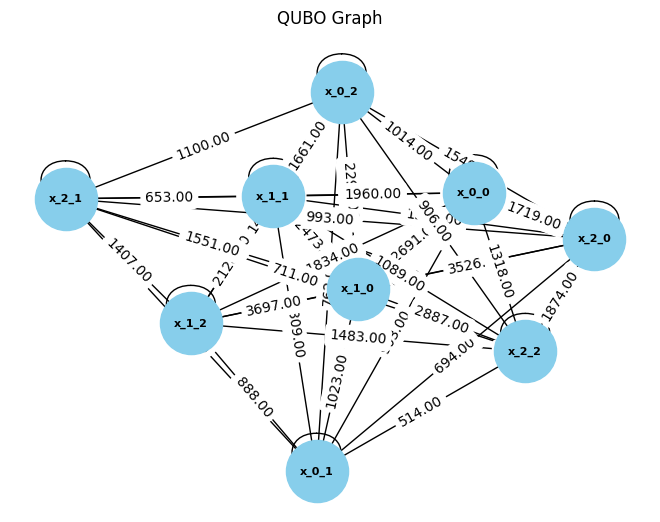

In [219]:
G = nx.Graph()

for edge, weight in qubo_matrix.items():
    node1, node2 = edge
    G.add_edge(node1, node2, weight=weight)

pos = nx.spring_layout(G)
edge_labels = {(node1, node2): f'{weight:.2f}' for (node1, node2), weight in qubo_matrix.items()}
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2000, node_color='skyblue', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("QUBO Graph")
plt.show()

In [240]:
sampler = EmbeddingComposite(DWaveSampler(token='DEV-9e6ad578ad1d5c10a1365ce2b037e444b5e8b230'))
sampleset = sampler.sample_qubo(qubo_matrix, num_reads=1000)

In [241]:
min_energy = float('inf')
min_sample = None

for sample, energy in zip(sampleset.samples(), sampleset.record['energy']):
    print(f"Sample: {sample}, Energy: {energy}")

    if energy < min_energy:
        min_energy = energy
        min_sample = sample

print(f"\nMinimum Energy Solution: {min_sample}, Energy: {min_energy}")

Sample: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 1, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0}, Energy: -30.0
Sample: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 1, 'x_2_2': 0}, Energy: -30.0
Sample: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 1, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0}, Energy: -30.0
Sample: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 1, 'x_2_1': 0, 'x_2_2': 0}, Energy: -30.0
Sample: {'x_0_0': 0, 'x_0_1': 1, 'x_0_2': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0}, Energy: -30.0
Sample: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 0, 'x_1_0': 1, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0}, Energy: -30.0
Sample: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0}, Energy: 0.0
Sample: {'x_0_0': 0, 'x_0_1': 1, 'x_0_2': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 

In [242]:
lowest_energy_solution = sampleset.first.sample
lowest_energy = sampleset.first.energy

print("Lowest Energy Solution:", lowest_energy_solution)
print("Energy:", lowest_energy)

Lowest Energy Solution: {'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 1, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 0}
Energy: -30.0
